**Importing packages:**

In [51]:
%matplotlib inline

# Package imports
import numpy as np
import pandas as pd
import geopandas as gpd
import ssl
import datetime

# from IPython.display import set_matplotlib_formats
import matplotlib_inline.backend_inline

# plotting setup
import matplotlib.pyplot as plt
import plotly.express as px
import contextily as cx
import pyproj

# allow import of own scripts 
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# import own functions
from src.load_taxi_data import load_taxi_data
from src.taxi_zones_loader import taxi_zones_loader
from src.preprocess_data import preprocess_data
from src.keep_correct_year import keep_correct_year
from src.keep_correct_month import keep_correct_month
from src.remove_routes import remove_routes

# disable_certificate_check
ssl._create_default_https_context = ssl._create_unverified_context
# set matplotlib formats
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")
# make inline plots vector graphics
%matplotlib inline

**Variables:**

In [52]:
# variables
YEAR = "2019"
MONTH = "01"
PICKUP_ZONE = 132

DATA_PATH = '../dat/'
FIG_PATH = '../doc/fig/'

**Download data and save on disk:**

In [53]:
# get taxi data
if os.path.isfile(DATA_PATH + 'df_taxi_%s_%s.csv' % (YEAR, MONTH)):
    print("Dataset %s already downloaded." % 'df_taxi_%s_%s.csv' % (YEAR, MONTH))
else:
    # download taxi data for given month and year
    df_taxi = load_taxi_data(['yellow', 'green', 'fhv', 'fhvhv'], [int(YEAR)], [int(MONTH)])
    # save data as csv on disk
    df_taxi.to_csv(DATA_PATH + 'df_taxi_%s_%s.csv' % (YEAR, MONTH), encoding='utf-8')

Dataset df_taxi_2019_01.csv already downloaded.


**Data acquisition:**

In [54]:
# read previously saved dataframe from csv file from disk
df_taxi_raw = pd.read_csv(DATA_PATH + 'df_taxi_%s_%s.csv'%(YEAR, MONTH))
print(df_taxi_raw.head())

   Unnamed: 0      pickup_datetime     dropoff_datetime  PULocationID  \
0           0  2019-01-01 00:46:40  2019-01-01 00:53:20         151.0   
1           1  2019-01-01 00:59:47  2019-01-01 01:18:59         239.0   
2           2  2018-12-21 13:48:30  2018-12-21 13:52:40         236.0   
3           3  2018-11-28 15:52:25  2018-11-28 15:55:45         193.0   
4           4  2018-11-28 15:56:57  2018-11-28 15:58:33         193.0   

   DOLocationID   fleet  
0         239.0  yellow  
1         246.0  yellow  
2         236.0  yellow  
3         193.0  yellow  
4         193.0  yellow  


**Preprocessing:**

_Caution: The data is provided in a bad condition: There is data from 2018 in the 2019 data set!_

In [37]:
# remove nan values
df_taxi = preprocess_data(df_taxi_raw)
# remove rides outside nyc
df_taxi = remove_routes(df_taxi)
# remove wrong years from data set
df_taxi = keep_correct_year(df_taxi, YEAR)
# remove wrong months from data set
#df_taxi = keep_correct_month(df_taxi, MONTH)

print(df_taxi.head())

About 5.8060% of the entire data could not be used due to missing information (NaN).
About 5.5694% of the entire data could not be used because "PULocationID" or "DOLocationID" are outside the city.
About 0.0014% of the entire data could not be used because they contained the wrong year.
       pickup_datetime     dropoff_datetime  PULocationID  DOLocationID  \
0  2019-01-01 00:46:40  2019-01-01 00:53:20           151           239   
1  2019-01-01 00:59:47  2019-01-01 01:18:59           239           246   
7  2019-01-01 00:21:28  2019-01-01 00:28:37           163           229   
8  2019-01-01 00:32:01  2019-01-01 00:45:39           229             7   
9  2019-01-01 00:57:32  2019-01-01 01:09:32           141           234   

    fleet  
0  yellow  
1  yellow  
7  yellow  
8  yellow  
9  yellow  


In [55]:
# preprocessing of dataset
def dataset_preprocessing(df, year):
    # remove nan values
    df = preprocess_data(df)
    # remove rides outside nyc
    df = remove_routes(df)
    # remove wrong years from data set
    df = keep_correct_year(df, year)
    return df

In [56]:
# get trip duration (target variable)
trip_duration = (pd.to_datetime(df_taxi['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')) - (pd.to_datetime(df_taxi['pickup_datetime'], format='%Y-%m-%d %H:%M:%S'))
# add trip duration to dataframe
df_taxi.insert(len(df_taxi.columns), 'trip_duration', trip_duration.astype('timedelta64[m]'))
# filter negative values out
df_taxi = df_taxi[df_taxi['trip_duration'] > 0]

ValueError: cannot insert trip_duration, already exists

**Read SHP:**

In [ ]:
# read SHP data from file and plot head
geodf_nyc = gpd.read_file("../dat/taxi_zones/taxi_zones.shp")

# rest index to later get interpretable results
geodf_nyc.set_index('LocationID', inplace=True);
# rest index to later get interpretable results
#geodf_nyc = geodf_nyc.set_index('OBJECTID', inplace=True); # LocationID

print(geodf_nyc.head())

**Plotting Functions:**

In [ ]:
# plot advanced map
def plot_advanced_map(geodf, target_variable, title):
    # Re-set projection of geodata
    geodf = geodf.to_crs(epsg=3857)

    ax = geodf.plot(figsize=(7.5, 7.5), 
                    column=target_variable,
                    legend="true",
                    legend_kwds={'shrink': 0.815},
                    alpha=0.6, 
                    edgecolor='k',
                    cmap='hot_r')
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1.15,0.5))
    
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
    ax.set_axis_off()
    
    ax.set_title(title, fontsize = 15)

    plt.savefig(FIG_PATH + '%s.pdf'%(title), format='pdf', dpi=1200)

In [ ]:
# get average ride time
def get_average_ride_time(df_taxi, geodf_nyc, pickup_zone):
    # get subset of all rides startng in given pickup zone
    subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]
    print(subset.groupby(['DOLocationID']))
    
    gdf_average_ride_time = subset.groupby(['DOLocationID'])['trip_duration'].mean()
    
    #gdf_average_ride_time = fill_empty_rows(gdf_average_ride_time)
    gdf_average_ride_time.reindex(list(range(gdf_average_ride_time.index.min(),gdf_average_ride_time.index.max()+1)),fill_value=np.nan)
   
    # fix column names
    gdf_average_ride_time = gdf_average_ride_time.rename_axis('DOLocationID').reset_index(name='AverageRideTime')
    
    # merge 
    gdf_average_ride_time = geodf_nyc.merge(left_on='LocationID', right=gdf_average_ride_time, right_on='DOLocationID')
    
    return gdf_average_ride_time

In [ ]:
from matplotlib import rcParams
rcParams['font.family'] = 'Times'

# JFK
PICKUP_ZONE = 132
#PICKUP_ZONE = 138
gdf_average_ride_time = get_average_ride_time(df_taxi, geodf_nyc, PICKUP_ZONE)

plot_advanced_map(gdf_average_ride_time, "AverageRideTime", "Average ride time")
#plot_interactive_map(gdf_average_ride_time, "AverageRideTime", "Average ride time")

In [ ]:
# plot interactive map
def plot_interactive_map(geodf, target_variable, title):
    # Set geometry such that geopandas knows which column to use for plotting polygons, ...
    geodf.set_geometry("geometry");

    # re-set coordinates / projection:
    geodf.crs

    # convert projection system / coordinates which is necessary for plotly
    geodf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)

    # map as background
    fig = px.choropleth_mapbox(geodf, geojson=geodf.geometry, 
                        locations=geodf.index, color=target_variable,
                        color_continuous_scale=px.colors.sequential.YlOrRd,
                        hover_data=['zone', 'borough'],
                        mapbox_style="open-street-map",
                        labels = "test",
                        center = {"lat": 40.75, "lon": -73.95}, # {"lat": 40.707, "lon": -73.98},
                        zoom = 10.0, # 9.4
                        opacity=0.6,
                        title=title)

    # update 
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(
    title={
        'text': title,
        'y':0.90,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    
    fig.update_layout(
        font_family="Times",
        font_color="black",
        title_font_size = 20)

    '''
    fig.update_layout(legend=dict(title_font_family="Times",
                              font=dict(size= 30)))
        #legend=dict(font=dict(size= 20)))
    '''
    
    file_path = FIG_PATH + '%s.pdf'%(title).replace("/", "-")
    fig.write_image(file_path, width='820', height='720', format='pdf') # 820 720 width='1640', height='1440',
    
    fig.show()

**Functions to calculate the data for the statistics:**

In [57]:
def fill_empty_rows(dataframe):
    return (dataframe.reindex(list(range(dataframe.index.min(),dataframe.index.max()+1)),fill_value=0))

In [58]:
# get zone averges by taxi dataframe
def get_zone_stats(df_taxi, geodf_nyc):
    # count number of dropouts for each taxi zone
    df_dropouts = df_taxi.groupby('DOLocationID')['DOLocationID'].count()
    # fill empty rows with zero
    df_dropouts = fill_empty_rows(df_dropouts)
    # fix column names
    df_dropouts = df_dropouts.rename_axis('DOLocationID').reset_index(name='Dropouts')
    # merge datasets
    gdf_zone_stats = geodf_nyc.merge(left_on='LocationID', right=df_dropouts, right_on='DOLocationID')
    del df_dropouts

    # count number of pickups for each taxi zone
    df_pickups = df_taxi.groupby('PULocationID')['PULocationID'].count()
    # fill empty rows with zero
    df_pickups = fill_empty_rows(df_pickups)
    # fix column names
    df_pickups = df_pickups.rename_axis('PULocationID').reset_index(name='Pickups')
    # merge datasets
    gdf_zone_stats = gdf_zone_stats.merge(left_on='DOLocationID', right=df_pickups, right_on='PULocationID')
    del df_pickups
    
    # drop not needed columns
    gdf_zone_stats = gdf_zone_stats.drop(columns=['DOLocationID', 'PULocationID'])
    
    # return geodataframe
    return gdf_zone_stats

In [59]:
# get average ride time
def get_average_ride_time(df_taxi, geodf_nyc, pickup_zone):
    # get subset of all rides startng in given pickup zone
    subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]
    
    gdf_average_ride_time = subset.groupby(['DOLocationID'])['trip_duration'].mean()
    
    #gdf_average_ride_time = fill_empty_rows(gdf_average_ride_time)
    gdf_average_ride_time.reindex(list(range(gdf_average_ride_time.index.min(),gdf_average_ride_time.index.max()+1)),fill_value=np.nan)
   
    # fix column names
    gdf_average_ride_time = gdf_average_ride_time.rename_axis('DOLocationID').reset_index(name='AverageRideTime')
    
    # merge 
    gdf_average_ride_time = geodf_nyc.merge(left_on='LocationID', right=gdf_average_ride_time, right_on='DOLocationID')
    
    return gdf_average_ride_time

In [60]:
# get dropout distribution by given pickup zone
def get_dropout_distribution_by_pickup_zone(df_taxi, geodf_nyc, pickup_zone):
    # get subset of all rides startng in given pickup zone
    subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]
    
    # count number of drop-offs of subset for each taxi zone
    df_dropout_distribution = subset.groupby('DOLocationID')['DOLocationID'].count()

    # fill empty rows with zero
    df_dropout_distribution = fill_empty_rows(df_dropout_distribution)
   
    # fix column names
    df_dropout_distribution = df_dropout_distribution.rename_axis('DOLocationID').reset_index(name='DropoutDistribution')
    
    # merge 
    gdf_dropouts_by_pickup_zone = geodf_nyc.merge(left_on='LocationID', right=df_dropout_distribution, right_on='DOLocationID')
    
    return gdf_dropouts_by_pickup_zone

In [61]:
gdf_zone_stats = get_zone_stats(df_taxi, geodf_nyc)
plot_interactive_map(gdf_zone_stats, "Dropouts", "Dropouts per Zone in %s/%s"%(MONTH, YEAR))
plot_interactive_map(gdf_zone_stats, "Pickups", "Pickups per Zone in %s/%s"%(MONTH, YEAR))

NameError: name 'plot_interactive_map' is not defined

In [ ]:
gdf_dropout_distribution = get_dropout_distribution_by_pickup_zone(df_taxi, geodf_nyc, PICKUP_ZONE)
plot_interactive_map(gdf_dropout_distribution, "DropoutDistribution", "Dropout Distribution from pickup zone %s in %s/%s"%(PICKUP_ZONE,MONTH, YEAR))

In [ ]:
# JFK
PICKUP_ZONE = 132
#PICKUP_ZONE = 138
gdf_average_ride_time = get_average_ride_time(df_taxi, geodf_nyc, PICKUP_ZONE)
plot_advanced_map(gdf_average_ride_time, "AverageRideTime", "Average ride time")
#plot_interactive_map(gdf_average_ride_time, "AverageRideTime", "Average ride time")

In [64]:
def prepare_data_for_route_between_two_zones(df_taxi): 
    # JFK Airport (Queens)
    pickup_zone = 132
    # LaGuardia Airport (Queens)
    dropout_zone = 138

    # only keep rides starting from JFK Airport going to LaGuardia Airport
    df_route_subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]
    df_route_subset = df_route_subset[df_route_subset["DOLocationID"] == dropout_zone]

    # remove outlier
    Q1 = df_route_subset.quantile(0.25)
    Q3 = df_route_subset.quantile(0.75)
    IQR = Q3 - Q1
    df_route_subset = df_route_subset[~((df_route_subset < (Q1 - 1.5 * IQR)) |(df_route_subset > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    return df_route_subset

In [65]:
def get_df_with_pickup_times_in_bins(df_route_subset):
    '''
    df_route_subset['pickup_datetime'] = pd.to_datetime(df_route_subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    start_date = '%s 00:00:00'%(date)
    end_date = '%s 23:59:59'%(date)
    mask = (df_route_subset['pickup_datetime'] > start_date) & (df_route_subset['pickup_datetime'] <= end_date)
    df_route_subset = df_route_subset.loc[mask]
    '''
    # convert string into datetime format to only keep date
    df_route_subset['pickup_datetime'] = pd.to_datetime(df_route_subset['pickup_datetime'], format='%Y-%m-%d')
    
    # define the bins
    bins = list(range(0,24+1))

    # custom labels
    labels = []
    for hour in bins:
        if hour != 24:
            hour = "%02d" % (hour,)
            labels.append("%s:00-%s:59"%(hour, hour))

    # add the bins to the dataframe
    df_route_subset['time bin'] = pd.cut(df_route_subset.pickup_datetime.dt.hour, bins, labels=labels, right=False)

    # groupby Time Bin and aggregate a list for the observations, and mean
    df_route_subset = df_route_subset.groupby('time bin', as_index=False)['trip_duration'].agg([list, 'mean'])

    return df_route_subset

In [66]:
from tqdm.notebook import tqdm as tqdm
from datetime import date
from calendar import monthrange
from datetime import datetime

df_monday_travel_time = pd.DataFrame()
df_tuesday_travel_time = pd.DataFrame()
df_wednesday_travel_time = pd.DataFrame()
df_thursday_travel_time = pd.DataFrame()
df_friday_travel_time = pd.DataFrame()
df_saturday_travel_time = pd.DataFrame()
df_sunday_travel_time = pd.DataFrame()
# download data for years between 2015 and 2021
for year in range(2019, 2020):
    # download data for months between 01 and 12
    for month in tqdm(range(1, 13), desc="Loading data from disk of year: %s"%(year)):
        # skip months after june 2021, because data is not available
        if not (year == 2021 and month >= 7):
            # leading zero if number as only one digit
            month = "%02d" % (month,)
            if os.path.isfile('../dat/df_taxi_%s_%s.csv'%(year, month)):
                # read dataframe
                df_taxi = pd.read_csv("../dat/df_taxi_%s_%s.csv"%(str(year), str(month)))
                # dataset preprocessing
                df_taxi = dataset_preprocessing(df_taxi, year)
                # get trip duration (target variable)
                trip_duration = (pd.to_datetime(df_taxi['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')) - (pd.to_datetime(df_taxi['pickup_datetime'], format='%Y-%m-%d %H:%M:%S'))
                # add trip duration to dataframe
                df_taxi.insert(len(df_taxi.columns), 'trip_duration', trip_duration.astype('timedelta64[m]'))

                # prepare data for route between two zones
                df_route_subset = prepare_data_for_route_between_two_zones(df_taxi)
                
                # convert string into datetime format to only keep date
                df_route_subset['aux_date'] = pd.to_datetime(df_route_subset['pickup_datetime'], format='%Y-%m-%d').dt.date
                # store date as string
                df_route_subset['aux_date'] = df_route_subset['aux_date'].astype(str)
                
                # convert string into datetime format to only keep date
                df_route_subset['aux_time'] = pd.to_datetime(df_route_subset['pickup_datetime'], format='%Y-%m-%d').dt.date
                # store date as string
                df_route_subset['aux_time'] = df_route_subset['aux_date'].astype(str)
                
                # get amount of days of month X in year Y
                days = monthrange(int(year),int(month))[1]
                # for every day in the month
                for day in range(1, days + 1):
                    # leading zero if number as only one digit
                    day = "%02d" % (day,)
                    # composite date from loop
                    date = '%s-%s-%s'%(year, month, day)
                    
                    df_day_subset = df_route_subset[df_route_subset['aux_date'] == date]
                    
                    ### get dataframe with pickup times in bins
                    ###df_pickup_times_in_bins = get_df_with_pickup_times_in_bins(df_route_subset, date)
                    # get weekday of date
                    weekday = datetime.strptime(date, '%Y-%m-%d').weekday()
                    
                    if weekday == 0:
                        df_monday_travel_time = df_monday_travel_time.append(df_day_subset)
                    elif weekday == 1:
                        df_tuesday_travel_time = df_tuesday_travel_time.append(df_day_subset)
                    elif weekday == 2:
                        df_wednesday_travel_time = df_wednesday_travel_time.append(df_day_subset)
                    elif weekday == 3:
                        df_thursday_travel_time = df_thursday_travel_time.append(df_day_subset)
                    elif weekday == 4:
                        df_friday_travel_time = df_friday_travel_time.append(df_day_subset)
                    elif weekday == 5:
                        df_saturday_travel_time = df_saturday_travel_time.append(df_day_subset)
                    elif weekday == 6:
                        df_sunday_travel_time = df_sunday_travel_time.append(df_day_subset)
            else:
                print("File does not exist!")
                
df_monday_travel_time = get_df_with_pickup_times_in_bins(df_monday_travel_time)
df_tuesday_travel_time = get_df_with_pickup_times_in_bins(df_tuesday_travel_time)
df_wednesday_travel_time = get_df_with_pickup_times_in_bins(df_wednesday_travel_time)
df_thursday_travel_time = get_df_with_pickup_times_in_bins(df_thursday_travel_time)
df_friday_travel_time = get_df_with_pickup_times_in_bins(df_friday_travel_time)
df_saturday_travel_time = get_df_with_pickup_times_in_bins(df_saturday_travel_time)
df_sunday_travel_time = get_df_with_pickup_times_in_bins(df_sunday_travel_time)

Loading data from disk of year: 2019:   0%|          | 0/1 [00:00<?, ?it/s]

About 5.8060% of the entire data could not be used due to missing information (NaN).
About 5.5694% of the entire data could not be used because "PULocationID" or "DOLocationID" are outside the city.
About 0.0014% of the entire data could not be used because they contained the wrong year.


/var/folders/f1/tnzvv5l54c36z9nn_dy7v_0c0000gn/T/ipykernel_80125/2294969017.py:15: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_route_subset = df_route_subset[~((df_route_subset < (Q1 - 1.5 * IQR)) |(df_route_subset > (Q3 + 1.5 * IQR))).any(axis=1)]


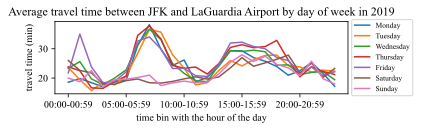

In [73]:
from tueplots import bundles

with plt.rc_context(bundles.neurips2021()):
    # initiate plot
    ax = df_monday_travel_time.plot(label="Monday")
    df_tuesday_travel_time.plot(ax=ax, label="Tuesday")
    df_wednesday_travel_time.plot(ax=ax, label="Wednesday")
    df_thursday_travel_time.plot(ax=ax, label="Thursday")
    df_friday_travel_time.plot(ax=ax, label="Friday")
    df_saturday_travel_time.plot(ax=ax, label="Saturday")
    df_sunday_travel_time.plot(ax=ax, label="Sunday")
    
    # legend settings
    ax.legend(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], prop={'size': 7.5}, loc='center left', bbox_to_anchor=(1, 0.5))

    # set title
    ax.set_title('Average travel time between JFK and LaGuardia Airport by day of week in 2019')
    # set x label
    ax.set_xlabel('time bin with the hour of the day')
    # set y label
    ax.set_ylabel('travel time (min)')
    
    fig = plt.gcf()
    # show plot
    plt.show()
    # save figure
    fig.savefig(FIG_PATH + 'travel-time.pdf',bbox_inches='tight', dpi=400)

In [469]:
# composite date from loop
date = '%s-%s-%s'%("2019", "02", "01")

weekday = datetime.strptime(date, '%Y-%m-%d').weekday()

print(weekday)

4


1760


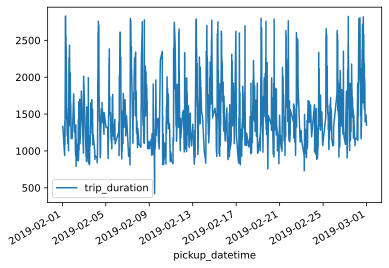

In [455]:
df_route_subset['pickup_datetime'] = pd.to_datetime(df_route_subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
start_date = '2019-02-01 00:00:00'
end_date = '2019-02-28 23:59:59'
mask = (df_route_subset['pickup_datetime'] > start_date) & (df_route_subset['pickup_datetime'] <= end_date)

df_route_subset = df_route_subset.loc[mask]

df_route_subset.plot(x='pickup_datetime', y='trip_duration')

print(len(df_route_subset))

In [456]:
# define the bins
bins = list(range(0,24+1))

# custom labels
labels = []
for hour in bins:
    if hour != 24:
        hour = "%02d" % (hour,)
        labels.append("%s:00-%s:59"%(hour, hour))

# add the bins to the dataframe
df_route_subset['time bin'] = pd.cut(df_route_subset.pickup_datetime.dt.hour, bins, labels=labels, right=False)

# groupby Time Bin and aggregate a list for the observations, and mean
df_route_subset = df_route_subset.groupby('time bin', as_index=False)['trip_duration'].agg([list, 'mean'])

print(df_route_subset)

# change the column names, if desired
#df_route_subset.columns = ['X Observations', 'X mean']

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
['00:00-00:59', '01:00-01:59', '02:00-02:59', '03:00-03:59', '04:00-04:59', '05:00-05:59', '06:00-06:59', '07:00-07:59', '08:00-08:59', '09:00-09:59', '10:00-10:59', '11:00-11:59', '12:00-12:59', '13:00-13:59', '14:00-14:59', '15:00-15:59', '16:00-16:59', '17:00-17:59', '18:00-18:59', '19:00-19:59', '20:00-20:59', '21:00-21:59', '22:00-22:59', '23:00-23:59']
                                                          list         mean
Time Bin                                                                   
00:00-00:59  [1773.0, 1316.0, 1029.0, 2230.0, 956.0, 869.0,...  1275.000000
01:00-01:59  [1333.0, 1094.0, 1061.0, 1522.0, 994.0, 1580.0...  1221.888889
02:00-02:59                            [1259.0, 925.0, 1166.0]  1116.666667
03:00-03:59  [1548.0, 821.0, 1436.0, 1581.0, 1055.0, 1030.0...  1325.428571
04:00-04:59  [1243.0, 998.0, 929.0, 944.0, 904.0, 841.0, 13...  1115.607143
05:00-05:59  [13

            pickup_datetime     dropoff_datetime  PULocationID  DOLocationID  \
11165   2019-02-01 01:00:22  2019-02-01 01:22:35           132           138   
17374   2019-02-01 05:45:16  2019-02-01 06:07:02           132           138   
18521   2019-02-01 05:00:46  2019-02-01 05:16:23           132           138   
18914   2019-02-01 05:43:44  2019-02-01 06:01:49           132           138   
19096   2019-02-01 05:26:23  2019-02-01 05:49:45           132           138   
...                     ...                  ...           ...           ...   
8760879 2019-02-20 11:52:49  2019-02-20 12:39:17           132           138   
8937547 2019-02-23 08:48:09  2019-02-23 09:06:04           132           138   
9063025 2019-02-25 12:45:52  2019-02-25 13:06:52           132           138   
9210028 2019-02-27 15:01:00  2019-02-27 15:37:18           132           138   
9220761 2019-02-27 18:41:20  2019-02-27 19:06:27           132           138   

          fleet  trip_duration  
11165 

<AxesSubplot:xlabel='pickup_datetime'>

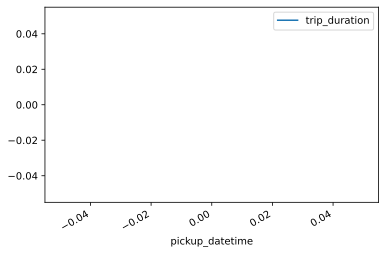

In [401]:
#df_route_subset.plot(x='pickup_datetime', y='trip_duration')
df_route_subset['pickup_datetime'] = pd.to_datetime(df_route_subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(df_route_subset)
# filter by single day
df_route_subset = df_route_subset[df_route_subset['pickup_datetime'].dt.strftime('%Y-%m-%d') == '2019-01-01']

print(df_route_subset['pickup_datetime'].dt.strftime('%Y-%m-%d'))
print(df_route_subset)

df.plot(x='pickup_datetime', y='trip_duration')

In [ ]:
# define the bins
bins = [0, 6, 12, 18, 24]

# add custom labels if desired
labels = ['00:00-05:59', '06:00-11:59', '12:00-17:59', '18:00-23:59']

# add the bins to the dataframe
df['Time Bin'] = pd.cut(df.date.dt.hour, bins, labels=labels, right=False)

# display(df.head())
                  date  x     Time Bin
0  2020-09-21 00:00:00  2  00:00-05:59
1  2020-09-21 01:00:00  4  00:00-05:59
2  2020-09-21 02:00:00  1  00:00-05:59
3  2020-09-21 03:00:00  5  00:00-05:59
4  2020-09-21 04:00:00  2  00:00-05:59

# display(df.tail())
                    date  x     Time Bin
1095 2020-11-05 15:00:00  2  12:00-17:59
1096 2020-11-05 16:00:00  3  12:00-17:59
1097 2020-11-05 17:00:00  1  12:00-17:59
1098 2020-11-05 18:00:00  2  18:00-23:59
1099 2020-11-05 19:00:00  2  18:00-23:59
                
                
# groupby Time Bin and aggregate a list for the observations, and mean
dfg = df.groupby('Time Bin', as_index=False)['x'].agg([list, 'mean'])

# change the column names, if desired
dfg.columns = ['X Observations', 'X mean']

# display(dfg)
                      X Observations    X mean
Time Bin                                 
00:00-05:59  [2, 4, 1, 5, 2, 2, ...]  4.416667
06:00-11:59  [9, 8, 4, 0, 3, 3, ...]  4.760870
12:00-17:59  [7, 7, 7, 0, 8, 4, ...]  4.384058
18:00-23:59  [3, 2, 6, 2, 6, 8, ...]  4.459559

KeyError: 'pickup_datetime'

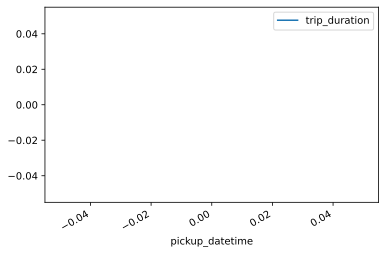

In [396]:
df.plot(x='pickup_datetime', y='trip_duration')

df['pickup_datetime'] = pd.to_datetime(subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
start_date = '2019-01-01 00:00:00'
end_date = '2019-01-07 00:00:00'
mask = (df['pickup_datetime'] > start_date) & (df['pickup_datetime'] <= end_date)
df = df.loc[mask]

df.plot(x='pickup_datetime', y='trip_duration')

<AxesSubplot:>

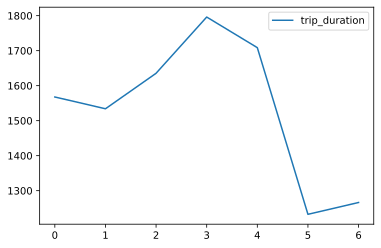

In [391]:
### täglich 
subset = testdf

subset = subset.assign(weekday = pd.to_datetime(subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.weekday) 

subset = subset.groupby(['weekday'])['trip_duration'].mean()

# fix column names
subset = subset.reset_index(name='trip_duration') 

subset[['trip_duration']].plot()

<AxesSubplot:>

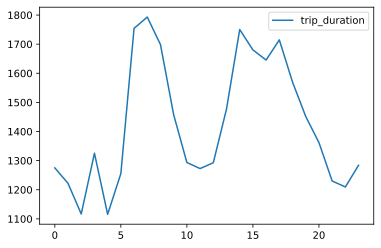

In [376]:
### stündlich 
subset = testdf

subset = subset.assign(hour = pd.to_datetime(subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour) 

subset = subset.groupby(['hour'])['trip_duration'].mean()

# fix column names
subset = subset.reset_index(name='trip_duration')

subset[['trip_duration']].plot()

<AxesSubplot:>

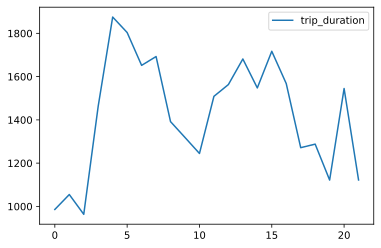

In [377]:
subset1 = testdf

subset1 = subset1[pd.to_datetime(subset1['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.weekday==0]

### stündlich am montag
subset1 = subset1.assign(hour = pd.to_datetime(subset1['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour) 

subset1 = subset1.groupby(['hour'])['trip_duration'].mean()

# fix column names
subset1 = subset1.reset_index(name='trip_duration')

subset1[['trip_duration']].plot()

In [378]:
subset1 = subset[pd.to_datetime(subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.weekday==3]

### stündlich am montag
subset1 = subset1.assign(hour = pd.to_datetime(subset1['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.hour) 

subset1 = subset1.groupby(['hour'])['trip_duration'].mean()

# fix column names
subset1 = subset1.reset_index(name='trip_duration')

subset1[['trip_duration']].plot()

KeyError: 'pickup_datetime'

In [379]:
#print(subset)

#print(type(subset["pickup_datetime"].date()))

#print(pd.to_datetime(subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.time)

# exact time
# subset = subset.assign(time = pd.to_datetime(subset['pickup_datetime'], format='%Y-%m-%d %H:%M:%S').dt.time)

#subset.plot(y='trip_duration', use_index=True)
#fig, axs = plt.subplots(figsize=(12, 4)
#from scipy.interpolate import interp1d

'''
# Define interpolators.
f_linear = interp1d(x, y)
f_cubic = interp1d(x, y, kind='cubic')

# Plot.
plt.plot(x, y, 'o', label='data')
plt.plot(xnew, f_linear(xnew), '-', label='linear')
plt.plot(xnew, f_cubic(xnew), '--', label='cubic')
plt.legend(loc='best')
plt.show()


print(subset)

def get_average_ride_time(df_taxi, geodf_nyc, pickup_zone):
    # get subset of all rides startng in given pickup zone
    subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]
    
    gdf_average_ride_time = subset.groupby(['DOLocationID'])['trip_duration'].mean()
'''

'\n# Define interpolators.\nf_linear = interp1d(x, y)\nf_cubic = interp1d(x, y, kind=\'cubic\')\n\n# Plot.\nplt.plot(x, y, \'o\', label=\'data\')\nplt.plot(xnew, f_linear(xnew), \'-\', label=\'linear\')\nplt.plot(xnew, f_cubic(xnew), \'--\', label=\'cubic\')\nplt.legend(loc=\'best\')\nplt.show()\n\n\nprint(subset)\n\ndef get_average_ride_time(df_taxi, geodf_nyc, pickup_zone):\n    # get subset of all rides startng in given pickup zone\n    subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]\n    \n    gdf_average_ride_time = subset.groupby([\'DOLocationID\'])[\'trip_duration\'].mean()\n'

In [ ]:
plot_interactive_map(gdf_zone_stats, "Pickups", "Pickups per Zone")

In [ ]:
# get zone id's
zone_ids = []
for i in range(len(nyc_geo_df)): zone_ids.append(i + 1)
    
# empty auxiliary list
rows = []
# for every zone
for zone_id in zone_ids:
    print(zone_id)
    
    # get pickups per zone
    pickups = len(data_nyc[data_nyc["PULocationID"] == zone_id]) # ["AnzahlFall"].sum()
    # get droputs per zone
    dropouts = len(data_nyc[data_nyc["DOLocationID"] == zone_id])
    
    # get average tip per pickup zone
    pu_average_tip = (data_nyc[data_nyc["PULocationID"] == zone_id]["tip_amount"].sum()) / pickups
    # get average tip per dropout zone
    do_average_tip = (data_nyc[data_nyc["DOLocationID"] == zone_id]["tip_amount"].sum()) / pickups
    
    do_zone = {}
    for dropout_zone in zone_ids:
        subset = data_nyc[data_nyc["PULocationID"] == zone_id]
        droupout_amount = len(subset[subset["DOLocationID"] == dropout_zone])
        do_zone[dropout_zone] = droupout_amount
    
    # add to auxiliary list
    rows.append([zone_id, pickups, dropouts, pu_average_tip, do_average_tip, do_zone])
    
# create dataframe with zone information
zone_df = pd.DataFrame(rows, columns=["LocationID", "Pickups", "Dropouts", "PUAverageTip", "DOAverageTip", "DropoutZone"])
# replace NaN values with zeros
zone_df = zone_df.fillna(0)

print(zone_df)

# merge 
nyc_geo_df = nyc_geo_df.merge(zone_df, on='LocationID')

In [ ]:
'''
def plot_dropout_zones(df_taxi, geodf_nyc, pickup_zone):
    # get list with zone id's
    zone_ids = []
    for zone_id in range(len(geodf_nyc)): zone_ids.append(zone_id + 1)

    # get subset of all rides in given pickup zone
    subset = df_taxi[df_taxi["PULocationID"] == pickup_zone]
    # empty dictionary for counting dropouts in the according zones
    dropout_zone = {}
    
    # for every zone
    for zone in zone_ids:
        # get amount of dropouts and fill dictionary
        dropout_zone[zone] = len(subset[subset["DOLocationID"] == zone])

    # create new dataframe for plotting
    dropout_df = pd.DataFrame(columns=['LocationID', 'Dropouts'])
    
    # fill dataframe with dropouts
    for zone_id in dropout_zone.keys():
        dropout_df = dropout_df.append({'LocationID': zone_id, 'Dropouts': dropout_zone[zone_id]}, ignore_index=True)                               

    # merge with nyc geo dataframe
    dropout_geo_df = geodf_nyc.merge(dropout_df, on='LocationID')
    
    return dropout_geo_df
    # dropout_geo_df.plot(column='Dropouts', cmap='hot', figsize=(7.5, 7.5))
'''

'''
# plot interactive map
def plot_interactive_map(geodf_nyc, target_variable, title):

    # Set geometry such that geopandas knows which column to use for plotting polygons, ...
    geodf_nyc.set_geometry("geometry");

    # re-set coordinates / projection:
    geodf_nyc.crs

    # convert projection system / coordinates which is necessary for plotly
    geodf_nyc.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)

    # map as background
    fig = px.choropleth_mapbox(geodf_nyc, geojson=geodf.geometry, 
                        locations=geodf.index, color=target_variable,
                        color_continuous_scale=px.colors.sequential.YlOrRd,
                        hover_data=['zone', 'borough'],
                        mapbox_style="open-street-map",
                        center = {"lat": 40.74, "lon": -73.99},
                        zoom = 8.5,
                        opacity=0.5,
                        title=title)

    # update 
    fig.update_geos(fitbounds="locations", visible=False)
    fig.show()
'''

In [358]:
test = get_zone_counter(df_taxi, geodf)
plot_advanced_map(test, "Pickups", "SWAG")

NameError: name 'get_zone_counter' is not defined